In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import shutil

source_path = '/content/drive/My Drive/ILSVRC2012_img_val.tar'

destination_path = '/content/ILSVRC2012_img_val.tar'

shutil.copy(source_path, destination_path)



Mounted at /content/drive


'/content/ILSVRC2012_img_val.tar'

In [ ]:
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz

!tar xzf ILSVRC2012_devkit_t12.tar.gz

--2024-06-06 01:27:11--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568145 (2.4M) [application/x-gzip]
Saving to: ‘ILSVRC2012_devkit_t12.tar.gz’

ILSVRC2012_devkit_t 100%[===================>]   2.45M  1.96MB/s    in 1.2s    

2024-06-06 01:27:13 (1.96 MB/s) - ‘ILSVRC2012_devkit_t12.tar.gz’ saved [2568145/2568145]



In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((232,232)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
val_data = torchvision.datasets.ImageNet(root="/content", split='val', transform=transforms )

In [ ]:
class_names = val_data.classes

('tench', 'Tinca tinca')


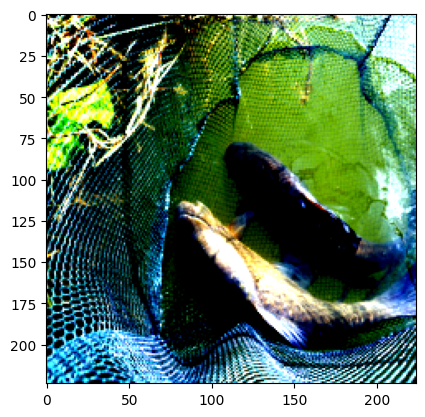

In [ ]:
plt.imshow(val_data[0][0].permute(1,2,0))
print(class_names[val_data[0][1]])

In [ ]:
val_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
len(class_names)

1000

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [ ]:
calib_size = int(0.05 * len(val_data))
remaining_size = len(val_data) - calib_size

calib_set, val_set = random_split(val_data, [calib_size, remaining_size])
print(len(calib_set))

2500


In [ ]:
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from tqdm.auto import tqdm

val_loss, val_acc = 0, 0
resnet50.eval()
with torch.inference_mode():
  for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    val_logits = resnet50(images)
    loss = loss_fn(val_logits, labels)
    val_loss += loss.item()
    val_acc += accuracy_function(labels, torch.argmax(val_logits, dim=1))

print(val_loss/len(val_loader), val_acc/len(val_loader))



  0%|          | 0/743 [00:00<?, ?it/s]

1.40926771433485 80.38848698968147
